In [1]:
from docplex.mp.model import Model
from docplex.mp.conflict_refiner import ConflictRefiner

import itertools as iter
from itertools import product

import time
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay
from scipy.stats import norm
from scipy.optimize import linprog

import random

from matplotlib import pyplot as plt


from mpl_toolkits.mplot3d import Axes3D

In [2]:
def f(p): #funcion a evaluar
    x = p[0]
    y = p[1]
    f = (1/y)*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))
    
    return f

#gsl_cdf_ugaussian_P == norm.cdf
#These functions compute the cumulative distribution functions P(x), Q(x) and their inverses for the unit Gaussian distribution.


#gsl_ran_ugaussian_pdf == norm.pdf
#These functions compute results for the unit Gaussian distribution. They are equivalent to the functions above with a standard deviation of one, sigma = 1.

def df1dx (x,y): #funcion a evaluar 
	f = (1/y)*((norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))-(norm.pdf(x)-x*(1-norm.cdf(x))))
	return f

def df1dy (x,y): #funcion a evaluar 
	f = -(1/(y*y))*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))+(1/y)*(norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))
	return f

def gradf(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y)])
def gradf2(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y),-1.0])

def fSH(a,x):
    return f(a) + np.dot(gradf(a),(x-a))

def to_points(triangulo):
    puntos = triangulo.points
    simplices = triangulo.simplices

    lista = []

    for pp in simplices:
        a = puntos[pp[0]]
        b = puntos[pp[1]]
        c = puntos[pp[2]]

        lista.append([a,b,c])

    return lista

def e_i(n,i):
    vector = np.zeros(n)
    vector[i-1] = np.ones(1)

    return vector

def pad(matriz, dimensiones):
    return np.pad(matriz,dimensiones, mode = 'constant', constant_values=(0, 0))

def linap (p,cuts, c,m):
    return max(c[str(cut)]+np.dot(m[str(cut)],p) for cut in cuts)

In [3]:
#Primera pasada

k=0

data = dict()

X = dict()
Y = dict()
D = dict()

lb = float(1.0e-6)
ub = float(5.0)

a = np.array([1.0e-6,lb])
b = np.array([ub,ub])

X[k] = e_i(2,2)*float(1.0e-6) #R^2
Y[k] = np.zeros(1) #R

D[k] = 1

deltaabs = np.infty
deltarel = np.infty

epsabs = float(1.0e-4) #No cambiar de 1.0e-5
epsrel = float(1.0e-4)

data[k] = {"OI": int(k), "X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k], "f(x)": f(X[k]), "difabs": f(a)-0.0, "difrel": 1}


while k < 1e6:
    Terminar = False

    soluciones = dict()

    p = X[k]

    for i in [1,2]:
        for c in [lb,ub]:
            
            lhsA = np.array([gradf(p),
                            e_i(2,i-1)])
            rhsb = np.array([np.dot(gradf(p),p)-f(p), c])

            ecs = np.linalg.solve(lhsA,rhsb)
            way = max(fSH(p,ecs),0.0)

            if np.less_equal(a/2.0,ecs).all() and np.less_equal(ecs,b+a/2.0).all():
                soluciones[str(ecs)] = (ecs,way)

    if len(soluciones) < 1.0:
        ecs_s = b
        way_s = max(fSH(p,b),0)
        Terminar = True

    else:
        maximo = -1*np.infty
        for key in soluciones.keys():
            val = soluciones[key]
            if val[1] > maximo:
                maximo = val[1]
                ecs_s = val[0]
                way_s = maximo
    
    deltaabs = f(ecs_s)-way_s
    deltarel = deltaabs/f(ecs_s)

    k+=1
    
    X[k] = ecs_s
    Y[k] = way_s
    
    if deltaabs <= epsabs or deltarel <= epsrel:
        D[k] = 0
        Terminar = True

    data[k] = {"OI": int(k), "X": X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}

    if Terminar:
        break

df = pd.DataFrame(data).transpose()

In [4]:
print(df.to_markdown())

|    |   OI | X                               |       X1 |      X2 |           Y |        f(x) |      difabs |   difrel |
|---:|-----:|:--------------------------------|---------:|--------:|------------:|------------:|------------:|---------:|
|  0 |    0 | [0.e+00 1.e-06]                 | 0        | 1e-06   | 0           | 0.398942    | 0.398942    |        1 |
|  1 |    1 | [7.97884379e-01 1.00000000e-06] | 0.797884 | 1e-06   | 0           | 0.398942    | 0.120656    |        1 |
|  2 |    2 | [1.36576102e+00 1.00000000e-06] | 1.36576  | 1e-06   | 1.38778e-17 | 0.120656    | 0.0395223   |        1 |
|  3 |    3 | [1.00000000e-06 3.65001186e+00] | 1e-06    | 3.65001 | 2.77556e-17 | 0.0395223   | 0.0684908   |        1 |
|  4 |    4 | [1.253086e+00 1.000000e-06]     | 1.25309  | 1e-06   | 0           | 0.0684908   | 0.0502616   |        1 |
|  5 |    5 | [1.00000000e-06 3.47110365e+00] | 1e-06    | 3.4711  | 2.77556e-17 | 0.0502616   | 0.0720185   |        1 |
|  6 |    6 | [1.2528708

c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


In [5]:
extremos = [[0.0,ub],[ub,lb],b]
for p in extremos:
    if p not in df["X"].values:
        k+=1
        X[k] = p
        Y[k] = 0.0
        data[k] = {"OI": int(k),"X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}
df = pd.DataFrame(data).transpose()

c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
print(df.to_markdown())

|    |   OI | X                               |       X1 |      X2 |           Y |        f(x) |      difabs |   difrel |
|---:|-----:|:--------------------------------|---------:|--------:|------------:|------------:|------------:|---------:|
|  0 |    0 | [0.e+00 1.e-06]                 | 0        | 1e-06   | 0           | 0.398942    | 0.398942    |        1 |
|  1 |    1 | [7.97884379e-01 1.00000000e-06] | 0.797884 | 1e-06   | 0           | 0.398942    | 0.120656    |        1 |
|  2 |    2 | [1.36576102e+00 1.00000000e-06] | 1.36576  | 1e-06   | 1.38778e-17 | 0.120656    | 0.0395223   |        1 |
|  3 |    3 | [1.00000000e-06 3.65001186e+00] | 1e-06    | 3.65001 | 2.77556e-17 | 0.0395223   | 0.0684908   |        1 |
|  4 |    4 | [1.253086e+00 1.000000e-06]     | 1.25309  | 1e-06   | 0           | 0.0684908   | 0.0502616   |        1 |
|  5 |    5 | [1.00000000e-06 3.47110365e+00] | 1e-06    | 3.4711  | 2.77556e-17 | 0.0502616   | 0.0720185   |        1 |
|  6 |    6 | [1.2528708

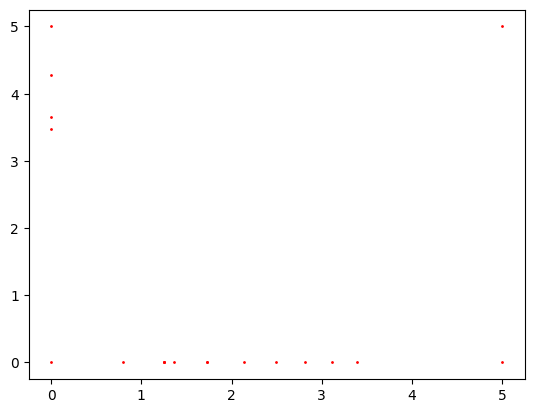

In [7]:
ex = df["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append((x[0]))
    py.append((x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

In [8]:
puntos_iniciales = df["X"].values.tolist()

#puntos_iniciales.append(np.array([lb,ub]))
#puntos_iniciales.append(np.array([ub,lb]))
puntos_iniciales = np.array(puntos_iniciales)

tri_inicial = Delaunay(puntos_iniciales, incremental= False)

In [9]:
#puntos_iniciales2 = np.log10(puntos_iniciales)

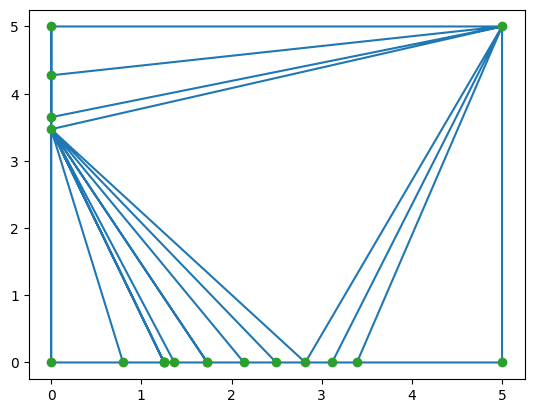

In [10]:
plt.triplot(puntos_iniciales[:,0], puntos_iniciales[:,1], tri_inicial.simplices)
plt.plot(puntos_iniciales[:,0], puntos_iniciales[:,1], 'o')
plt.show()

In [11]:
#plt.triplot(puntos_iniciales2[:,0], puntos_iniciales2[:,1], tri_inicial.simplices)
#plt.plot(puntos_iniciales2[:,0], puntos_iniciales2[:,1], 'o')
#plt.show()

In [12]:
#Segunda pasada
simplices = to_points(tri_inicial)

for simplex in simplices:
    nn = []
    Solus = []
    v = dict()
    v[1] = simplex[0]
    v[2] = simplex[1]
    v[3] = simplex[2]

    ro = np.array([v[1],
                   v[2],
                   v[3],
                   -e_i(2,1),
                   -e_i(2,2),
                     np.zeros(2)]).T
    A = np.array([gradf2(v[1]),
                gradf2(v[2]),
                gradf2(v[3])])
    B=  np.array([[np.dot(gradf(v[1]),v[1])-f(v[1]),
                  np.dot(gradf(v[2]),v[2])-f(v[2]),
                  np.dot(gradf(v[3]),v[3])-f(v[3])]])
    
    lhsA_eq = pad(ro,((0,1),(0,0))) + pad(np.array([e_i(6,1)+e_i(6,2)+e_i(6,3)]), ((2,0),(0,0)))
    lhsA_ub = pad(A, ((0,6),(3,0))) + pad(-np.array([e_i(6,1),e_i(6,2),e_i(6,3)]), ((3,3),(0,0)))+ pad(np.array([e_i(6,1),e_i(6,2),e_i(6,3)]), ((6,0),(0,0)))
    rhsB_eq = e_i(3,3)
    rhsB_ub = pad(B.T, ((0,6),(0,0))) + np.array([e_i(9,7)+e_i(9,8)+e_i(9,9)]).T

    FO = -e_i(6,6)
    for n in v.keys():
        FO+= e_i(6,n)*f(v[n])

    Sys = linprog(-FO, A_eq=lhsA_eq,b_eq=rhsB_eq,A_ub = lhsA_ub, b_ub = rhsB_ub, bounds = (None,None), options = {
        "tol" : 1.0e-8,
        "autoscale": True
        })
    N = []
    N2 = []
    if Sys.success:   #################
        Solus.append((Sys.x,0))
        x1 = Sys.x[0:2]
        for n in v.keys():
            lhsA_eq2 = pad(np.copy(lhsA_eq),((0,1),(0,0))) + pad(np.array([e_i(6,n)]),((3,0),(0,0)))
            rhsB_eq2 = e_i(4,3)#pad(np.copy(rhsB_eq),((0,1),(0,0)))
                
            lhsA_ub2 = np.copy(lhsA_ub)
            rhsB_ub2 = np.copy(rhsB_ub)
            
            FO2 = np.copy(FO)
            Sys2 = linprog(-FO2, A_eq=lhsA_eq2,b_eq=rhsB_eq2,A_ub = lhsA_ub2, b_ub = rhsB_ub2, bounds = (None,None), options = {
                    "tol" : 1.0e-8,
                    "autoscale": True
                    })
            if Sys2.success:
                Solus.append((Sys2.x,n))
            else:
                print("Sys2 not succesful...")
                break
                
            rhsB_eq3 = np.copy(rhsB_eq2)
            rhsB_ub3 = np.copy(rhsB_ub2)
                
            lhsA_ub3 = np.copy(lhsA_ub2)

            ll = Sys2.x[0:3]
            xx = Sys2.x[3:5]
            zz = Sys2.x[5]
            
            temp = np.zeros((3,2))
            temp[n-1] = xx

            contador = 1
            for m in v.keys():
                FO3 = -e_i(6,6)
                if m != n:
                    FO3[m] = zz
                    for l in v.keys():
                        if l !=m:
                            temp[l-1] = v[m]
                            FO3[l-1] = f(v[l])
                    
                    lhsA_eq3 = np.copy(lhsA_eq2)
                    lhsA_eq3[0:2] = np.zeros((2,6))
                    lhsA_eq3[0:2] += -pad(np.array([e_i(6,4),e_i(6,5)]),((0,0),(0,0))) + pad(temp.T,((0,0),(0,3)))

                    Sys3 = linprog(-FO3, A_eq=lhsA_eq3,b_eq=rhsB_eq3,A_ub = lhsA_ub3, b_ub = rhsB_ub3, bounds = (None,None), options = {
                        "tol" : 1.0e-8,
                        "autoscale": True
                        })
                    if not Sys3.success:
                        print("Sys3 number"+str(contador)+" not succesful...")
                        break
                    else:
                        if Sys3.fun < 1.0e-4:
                            Solus.append((Sys3.x,n))
                        else:
                            continue
                            #print("mhhhh..."+str(Sys3.fun))
                            #print(Sys3)
        #if np.less_equal(np.ones(3)*1.0e-8, Sys.x[0:3]).all(): #i.e., x \in int(\Delta)
            
    else:
        print("Por alguna razón no tiró soluciones.........")
        break
    
    
    #if not (len(Solus) >= 3 and len(Solus) <= 4):
    #    print("hay "+str(len(Solus))+" soluciones.......")
        #for sol in Solus:
        #    print("[", end="")
        #    print(sol[0][3], end=",")
        #    print(sol[0][4], end="],\n")
        #print("")
        #break
    
    maximo = -np.inf
    solucion_final = []
    for solucion,n in Solus:
        ecs = solucion[3:5]
        z = solucion[5]
        
        if f(ecs) > maximo+z:               #QUIZAS... AGREGARLE EL CORTE Z=0? (CON UN MAX{...,0}) !!!!!!!!!!!!!!!!!!!!!!!!!!!!
            solucion_final,nn = solucion,n
            maximo = f(ecs) - z             #x2 ^

    ecs_s = solucion_final[3:5]
    way_s = solucion_final[5]

    deltaabs = f(ecs_s) - way_s
    deltarel = deltaabs/f(ecs_s)
    
    if f(ecs_s) <= epsabs+way_s or deltarel <= epsrel:
        continue

    k+=1
    
    #if ecs_s[0] < 1.0e-4:
    #    ecs_s[0] = 1.0e-4

    X[k] = ecs_s
    Y[k] = way_s

    data[k] = {"OI": int(k), "X" :  X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(ecs_s),"difabs": deltaabs, "difrel":deltarel}

    if nn != 0:
        for n in v.keys():
            if n != nn:
                simplices.append([ecs_s,v[n],v[nn]])#= #np.append(simplices, np.array([[ecs_s,v[n],v[nn]]]), axis=0)
    else:    
        for n in v.keys():
            simplices.append([ecs_s,v[n],v[n%3+1]]) #= np.append(simplices, np.array([[ecs_s,v[n],v[n%3+1]]]), axis=0)
    if k+1 == 250:
        break
df2 = pd.DataFrame(data).transpose()

c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:89: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:89: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\scipy\optimize\_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.71103e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\scipy\optimize\_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.94876e

In [13]:
print(simplex)

[array([0.26196313, 3.62008356]), array([0.59893688, 3.81172316]), array([1.09409121, 3.94541368])]


In [14]:
As = np.array([[123, 234, 345]])

In [15]:
L = [0,1,2,3]
for n in L:
    print(n)

    if n == 2:
        L.append(4)

0
1
2
3
4


In [16]:
flag = False
for n in As:
    print(n)
    if flag:
        break
    As = np.append(As, np.array([[7,7,7]]), axis=0)
    flag = True


[123 234 345]


In [17]:
As

array([[123, 234, 345],
       [  7,   7,   7]])

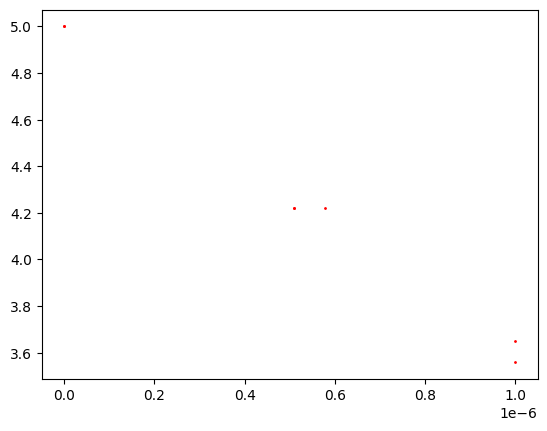

In [18]:
ptos = np.array([
[5.101485851533027e-07,4.220035677272642],
[5.777565971198939e-07,4.220035440698039],
[3.2307490016592055e-14,4.99999994424196],
[5.101486006964251e-07,4.220035663429284],
[3.042011087472929e-14,4.9999999429334725],
[9.999999774912283e-07,3.558358644256936],
[1.0000000042476032e-06,3.650011856213708],
])
px = []
py = []

for p in ptos:
    x = p
    px.append(x[0])
    py.append(x[1])


plt.scatter(px, py, s=1, c = "red")
plt.show()

In [19]:
for solucion,n in Solus:
    ecs = solucion[3:5]
    z = solucion[5]
        
    print(f(ecs)-z)

0.0016795658787534685
0.0016827522255148924
-4.747053444775773e-11
0.0016795658781654215
-3.3941842392248844e-10
0.0015476532606910343
-2.952948753576212e-10


In [20]:
print(k)
print(len(df2))
print(len(simplices))

249
250
564


In [21]:
print(lhsA_eq)

[[ 0.26196313  0.59893688  1.09409121 -1.          0.          0.        ]
 [ 3.62008356  3.81172316  3.94541368  0.         -1.          0.        ]
 [ 1.          1.          1.          0.          0.          0.        ]]


In [22]:
print(rhsB_ub)

[[-0.10956187]
 [-0.07204152]
 [-0.03471303]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]]


In [23]:
print(df2.to_markdown())

|     |   OI | X                                 |           X1 |          X2 |           Y |        f(x) |      difabs |     difrel |
|----:|-----:|:----------------------------------|-------------:|------------:|------------:|------------:|------------:|-----------:|
|   0 |    0 | [0.e+00 1.e-06]                   |  0           | 1e-06       | 0           | 0.398942    | 0.398942    | 1          |
|   1 |    1 | [7.97884379e-01 1.00000000e-06]   |  0.797884    | 1e-06       | 0           | 0.398942    | 0.120656    | 1          |
|   2 |    2 | [1.36576102e+00 1.00000000e-06]   |  1.36576     | 1e-06       | 1.38778e-17 | 0.120656    | 0.0395223   | 1          |
|   3 |    3 | [1.00000000e-06 3.65001186e+00]   |  1e-06       | 3.65001     | 2.77556e-17 | 0.0395223   | 0.0684908   | 1          |
|   4 |    4 | [1.253086e+00 1.000000e-06]       |  1.25309     | 1e-06       | 0           | 0.0684908   | 0.0502616   | 1          |
|   5 |    5 | [1.00000000e-06 3.47110365e+00]   |  1e-

### POR QUE HAY VALORES NEGATIVOS?

Por mientras, los parchearé a la mala...

c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


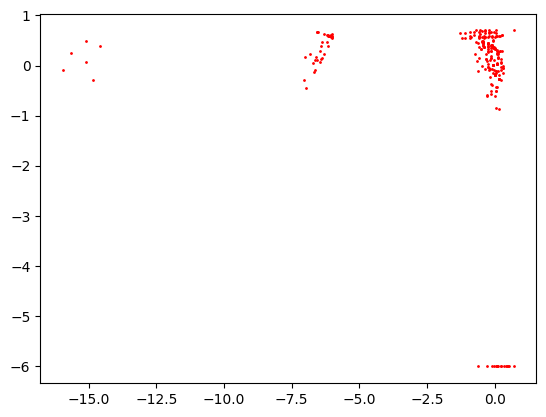

In [24]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(np.log10(x[0]))
    py.append(np.log10(x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

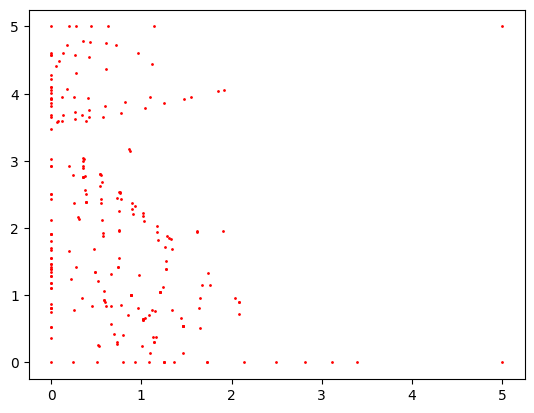

In [25]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(x[0])
    py.append(x[1])


plt.scatter(px, py, s=1, c = "red")
plt.show()

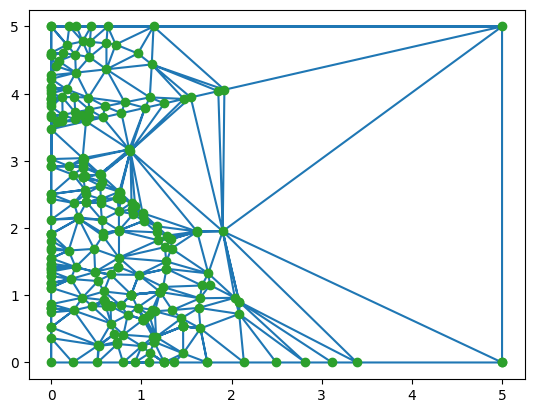

In [26]:
pepes = df2["X"].values.tolist()

pepes.append(np.array([lb,ub]))
pepes.append(np.array([ub,lb]))
pepes = np.array(pepes)

tri2 = Delaunay(pepes, incremental= False)
plt.triplot(pepes[:,0], pepes[:,1], tri2.simplices)
plt.plot(pepes[:,0], pepes[:,1], 'o')
plt.show()

In [27]:
print(len(df2)-len(df), len(df))

231 19


In [28]:
puntox1  = np.random.rand(1000,2)*(ub-lb)+lb
puntox2  = []

for n in puntox1:
    puntox2.append(np.array([n[0], n[1], f(n)]))
puntox2 = np.array(puntox2)


c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  after removing the cwd from sys.path.


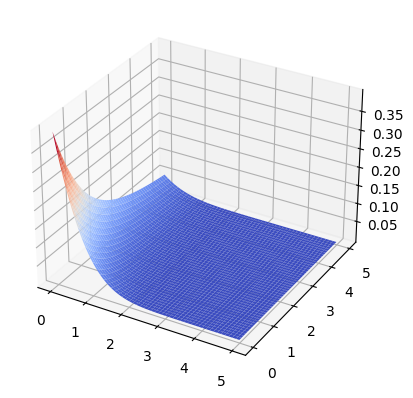

In [29]:
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

#X = puntox2[:,0]
X = np.arange(lb, ub, 0.01)
Y = np.arange(lb, ub, 0.01)
#Y = puntox2[:,1]

X,Y = np.meshgrid(X,Y)

Z = f((X,Y))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

plt.show()


In [30]:
Teacher_cuts = pd.read_excel(r'C:\Users\nico_\Desktop\mem\Codigos\profe\Code_C_shortage_barrido\cortes.xlsx', header = 0).iloc[:,1:3]

In [31]:
Teacher_cuts

,param x1:=,param y1:=
0,x,y
1,0,0.000001
2,0,1.596001
3,0,3.486001
4,1.12,0.000001
...,...,...
1997,1.158,0.951001
1998,0.326,1.490001
1999,2.046,1.885001
2000,0.027,1.219001


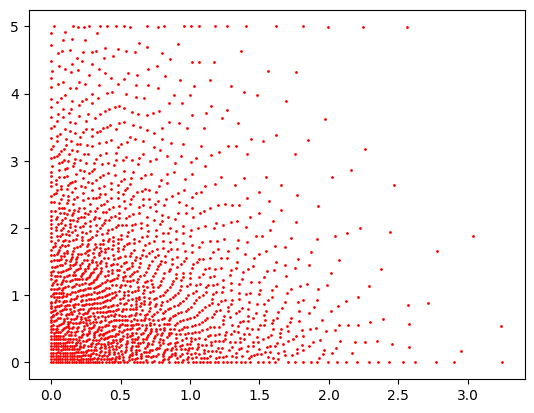

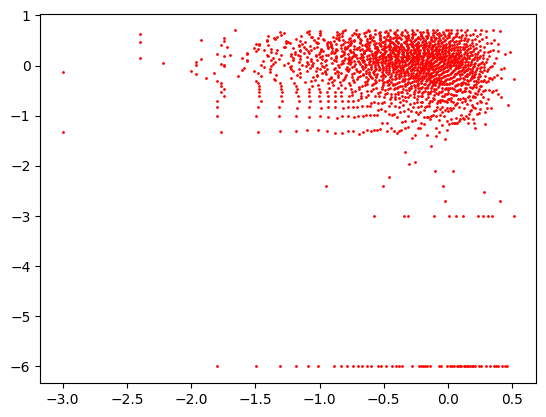

In [32]:
px = []
px2 = []
py = []
py2 = []

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        px.append(x[0])
        py.append(x[1])


plt.scatter(px, py, s=1, c = "red")
plt.show()

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        if x[0] == 0:
            continue
        px2.append(np.log10(x[0]))
        py2.append(np.log10(x[1]))


plt.scatter(px2, py2, s=1, c = "red")
plt.show()

## Comprobación ##


In [33]:
my_cuts = df2.iloc[:,1:4]

In [34]:
cuts = my_cuts.iloc[:,0].values

c = dict()
m = dict()

for cut in cuts:
    c[str(cut)] = f(cut) - np.dot(gradf(cut),(cut))
    m[str(cut)] = gradf(cut)

In [35]:
for n in range(0,100,1):
    linap(np.array([2,2]),cuts,c,m)

In [36]:
n=25

contador = 0
h = (ub-lb)/n
doomx = []
doomy = []

x = 0.0
while x < ub:
    y = lb
    while y < ub:
        z = linap(np.array([x,y]),cuts,c,m)
        if f((x,y)) >= epsabs + z:
            doomx.append(x)
            doomy.append(y)
            contador+=1
        y+= h
    x+= h

In [37]:
contador/n**2

0.1968

2k cortes: 3.84%

1k cortes: 7.52%

500 cortes: 12.48%

250 cortes: 19.68%


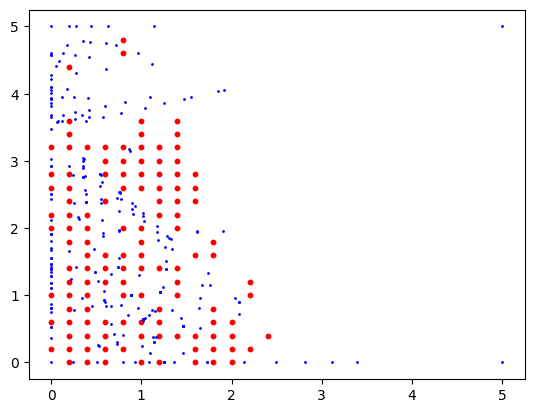

In [41]:
px = []
py = []

for n in range(len(doomx)):
    x = doomx[n]
    y = doomy[n]
    px.append(x)
    py.append(y)

plt.scatter(px, py, s=10, c = "red")


plt.scatter(df2["X1"], df2["X2"], s=1, c = "blue")
plt.show()